This file is used to train a CNN network that used for eye disease detection from fudus image

In [1]:
import torch
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

Build a dataloader for training

In [2]:
from torch.utils.data import Dataset, DataLoader
training_label_path="Training_Set/RFMiD_Training_Labels.csv"
training_image_path="Training_Set/Training/"
training_label = pd.read_csv(training_label_path)
tobedropped=[]
for i in range(len(training_label)):
    if training_label.iloc[i,2:].sum()>1:
        tobedropped.append(i)
training_label=training_label.drop(tobedropped)
transform = transforms.Compose([transforms.ToTensor()]) #used to transform image into tensor
class DiseaseDatsetT(Dataset):
    def __init__(self,dataframe,transform = None) -> None:
        super().__init__()
        self.data=dataframe
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self,idx):
        image_id = self.data.iloc[idx,0]
        image = Image.open("Training_Set/Training/"+str(image_id)+".png")
        image=self.transform(image)
        disease_labels=self.data.iloc[idx,1]
        if self.data.iloc[idx,1]!=1.0:
            return image,0      
        for j in range(2,46):
            if self.data.iloc[idx,j]==1.0:
                disease_labels=j-1  
        return image,disease_labels
dataset=DiseaseDatsetT(training_label,transform=transform)
batch_size=256
trainloader = DataLoader(dataset,batch_size=batch_size,shuffle=True)

validation_label_path="Evaluation_Set\\Evaluation_Set\\RFMiD_Validation_Labels.csv"
validation_label = pd.read_csv(validation_label_path)
tobedropped=[]
for i in range(len(validation_label)):
    if validation_label.iloc[i,2:].sum()>1:
        tobedropped.append(i)
validation_label=validation_label.drop(tobedropped)
class DiseaseDatsetV(Dataset):
    def __init__(self,dataframe,transform = None) -> None:
        super().__init__()
        self.data=dataframe
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self,idx):
        image_id = self.data.iloc[idx,0]
        image = Image.open("Evaluation_Set\\Evaluation_Set\\Validation\\"+str(image_id)+".png")
        image=self.transform(image)
        disease_labels=self.data.iloc[idx,1]
        if self.data.iloc[idx,1]!=1.0:
            return image,0
        
        for j in range(2,46):
            if self.data.iloc[idx,j]==1.0:
                disease_labels=j-1
                
        return image,disease_labels
datasetv=DiseaseDatsetV(validation_label,transform=transform)
valloader = DataLoader(datasetv,batch_size=batch_size,shuffle=True)


Defination of CNN

In [3]:
import torch.nn as nn
import torch.nn.functional as F
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(3,4,kernel_size=5)
        self.conv2=nn.Conv2d(4,8,kernel_size=5)
        self.conv3=nn.Conv2d(8,16,kernel_size=5)
        self.relu=nn.ReLU()
        self.maxpool=nn.MaxPool2d(kernel_size=2)
        self.fc1=nn.Linear(11424,324)
        self.fc2=nn.Linear(324,46)
        self.dropout=nn.Dropout(0.5)
    def forward(self,x):
        x0=x.size(0)
        x=self.maxpool(self.relu(self.conv1(x)))
        x=self.maxpool(self.relu(self.conv2(x)))
        x=self.maxpool(self.relu(self.conv3(x)))
        x=x.view(x0,-1)
        x=self.dropout(x)
        x=self.relu(self.fc1(x))
        x=self.dropout(x)
        x=F.log_softmax(self.fc2(x),dim=1)
        #x=self.relu(self.fc2(x))
        return x

Training the model

In [4]:
import torch.optim as optim
model_cnn=CNN().cuda()
optimizer = optim.Adam(model_cnn.parameters(),lr=1e-4*5)
criterion = nn.CrossEntropyLoss()
num_epochs = 30
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model_cnn.train()
    train_loss_sum = 0.0
    total_train_samples = 0
    # Training
    for inputs, labels in trainloader:
        inputs,labels=inputs.cuda(),labels.cuda()
        optimizer.zero_grad()
        outputs = model_cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss_sum += loss.item() * len(labels)
        total_train_samples += len(labels)
    avg_train_loss = train_loss_sum / total_train_samples 
    train_losses.append(avg_train_loss)
    # Validation
    model_cnn.eval()
    val_loss_sum = 0.0
    total_val_samples = 0
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.cuda(), labels.cuda()  
            outputs = model_cnn(inputs)
            loss = criterion(outputs, labels)
            val_loss_sum += loss.item() * len(labels)
            total_val_samples += len(labels)
    avg_val_loss = val_loss_sum / total_val_samples 
    val_losses.append(avg_val_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

Epoch [1/30], Train Loss: 3.2328, Val Loss: 2.7723
Epoch [2/30], Train Loss: 2.7163, Val Loss: 2.7347
Epoch [3/30], Train Loss: 2.6183, Val Loss: 2.6573
Epoch [4/30], Train Loss: 2.5925, Val Loss: 2.6281
Epoch [5/30], Train Loss: 2.5354, Val Loss: 2.6035
Epoch [6/30], Train Loss: 2.4912, Val Loss: 2.5772
Epoch [7/30], Train Loss: 2.4304, Val Loss: 2.5497
Epoch [8/30], Train Loss: 2.3981, Val Loss: 2.6070
Epoch [9/30], Train Loss: 2.3726, Val Loss: 2.5253
Epoch [10/30], Train Loss: 2.3328, Val Loss: 2.5191
Epoch [11/30], Train Loss: 2.3100, Val Loss: 2.4866
Epoch [12/30], Train Loss: 2.3003, Val Loss: 2.5121
Epoch [13/30], Train Loss: 2.2601, Val Loss: 2.4680
Epoch [14/30], Train Loss: 2.2256, Val Loss: 2.4489
Epoch [15/30], Train Loss: 2.2188, Val Loss: 2.4472
Epoch [16/30], Train Loss: 2.1984, Val Loss: 2.4257
Epoch [17/30], Train Loss: 2.1712, Val Loss: 2.4544
Epoch [18/30], Train Loss: 2.1677, Val Loss: 2.4460
Epoch [19/30], Train Loss: 2.1560, Val Loss: 2.3823
Epoch [20/30], Train 

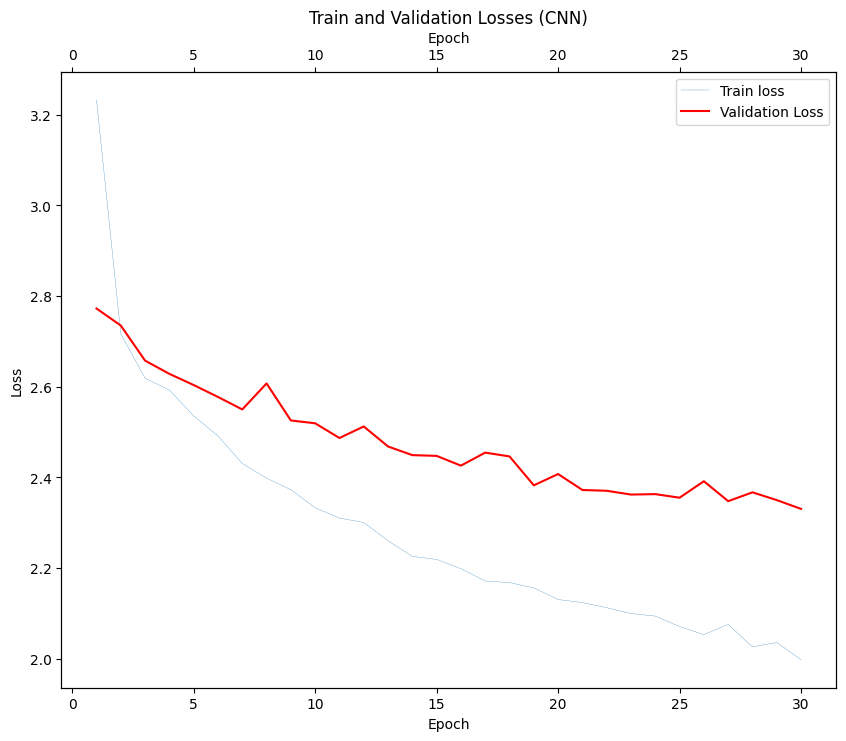

In [5]:
# Plot train and validation losses
xtwin=range(1,len(train_losses)+1)
fig,axes=plt.subplots()
fig.set_size_inches(10,8)
l1,=axes.plot(xtwin,train_losses,label="Train loss",linewidth=0.2)
x1,x2=axes.get_xlim()
axes.set_xlabel("Epoch")
axes.set_ylabel("Loss")
twin_axes=axes.twiny()
l2,=twin_axes.plot(range(1, num_epochs + 1), val_losses,'r-', label='Validation Loss')
twin_axes.set_xlabel("Epoch")
twin_axes.set_ylabel("Loss")
plt.legend(handles=[l1,l2])
plt.title('Train and Validation Losses (CNN)')
plt.show()

In [6]:
model_cnn.eval()
torch.save(model_cnn.state_dict(),"model_cnn.pt")